In [1]:
import time
import warnings

from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

from itertools import cycle, islice

import timeit

In [2]:
n_samples=1000

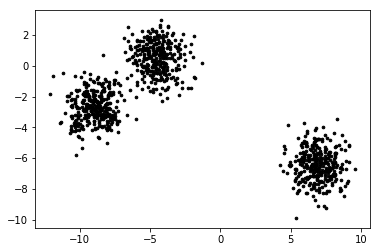

In [3]:
blobs = datasets.make_blobs(n_samples=n_samples, random_state=15)

points_blobs=blobs[0]

f1=points_blobs[0:((n_samples)), 0]
f2=points_blobs[0:((n_samples)), 1]

plt.scatter(f1, f2, c='black', s=7)

a = np.array(list(zip(f1, f2)))

## 1. Finding a conventionient way to build minibatches

In [4]:
print(a)

[[ -8.43157429  -3.27859587]
 [  7.3435412   -6.50409389]
 [-11.22211103  -0.48031088]
 ...
 [  7.77656922  -5.63147418]
 [ -5.57254889   0.93012253]
 [ -8.97958005  -2.29273386]]


In [5]:
start1 = time.time()
numrows = np.size(a, 0)
numcols = np.size(a, 1)
end1 = time.time()

In [6]:
start2 = time.time()
batch_s = 100
i = 0
neurows = numrows

# in order to be able to create a batch generator matrix, length of the data (numrows) is reduced accordingly

while (numrows / batch_s) != (numrows // batch_s):
    numrows = numrows - i
    i += 1
end2 = time.time()
print(numrows)
print(numrows / batch_s)



1000
10.0


In [7]:
# batch generator matrix = batches

batches = np.arange(numrows).reshape(batch_s, (numrows // batch_s))
a[batches[0]]

array([[ -8.43157429,  -3.27859587],
       [  7.3435412 ,  -6.50409389],
       [-11.22211103,  -0.48031088],
       [ -8.75787547,  -0.85608018],
       [ -2.69755772,  -1.43889928],
       [ -7.85183284,  -3.31344217],
       [ -8.95653589,  -4.02758281],
       [  6.77928432,  -6.14557786],
       [ -7.62518047,  -3.3706649 ],
       [ -5.06161773,   1.82390755]])

## 2.Centroid initiation

[[[-6.34528443  6.58075871]]

 [[-2.7202638  -7.87671925]]]


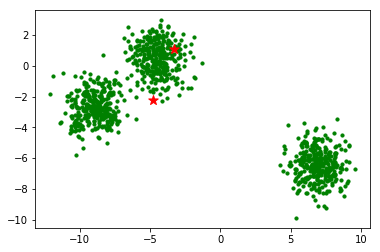

In [8]:
start3 = time.time()
f1= a[:, 0]
f2= a[:, 1]

plt.scatter(f1, f2, c='green', s=10)

X = (list(zip(f1, f2)))

k=2
c1 = np.random.choice(f1, size=k)
c2 = np.random.choice(f2, size=k)

plt.scatter(c1, c2, marker='*',c='red',s=100)

centroid_array = np.array([[np.random.choice(f1, size=k)], 
                           [np.random.choice(f2, size=k)]])
end3 = time.time()

print (centroid_array)

In [9]:
# assignment of the centroids

start4 = time.time()
def dist(cell_loc, cluster_number):

    return np.linalg.norm(a[cell_loc, :] - centroid_array[cluster_number - 1, :])

def assign_centroids(a_array):
    global nearest_centroid
    z = 0
    nearest_centroid = np.zeros([numrows, 1])
    
    # Loop over all datapoints
    while z < numrows:
        sml_distance = -1

        # Loop over every centroid
        j = 1
        while j <= k:

            if sml_distance == -1 or dist(z, j) < sml_distance:
                sml_distance = dist(z, j)
                nearest_centroid[z, 0] = j
            j += 1
        z += 1
end4 = time.time()

In [10]:
start5 = time.time()
n_iterations = (numrows // batch_s)
v = np.zeros((k, 1))
j = 1
ctrnew = centroid_array
while (j <= n_iterations):
    
        batch = (a[batches[j-1]]) # implementation of j-1 batches with the help of batch_generator matrix
        
        assign_centroids(batch)
        z = 0
        
        while (z < batch_s):
            c = ctrnew[int(nearest_centroid[z, 0])-1, :]
            v[int((nearest_centroid[z, 0]-1)), 0] =  int(v[int((nearest_centroid[z, 0]-1)), 0]) + 1
            n = 1/v[int((nearest_centroid[z, 0]-1)), 0]
            ctrnew[int(nearest_centroid[z, 0])-1, :] = c * (1-n) + a[z, :] * n
            z+=1
        j+=1
        
centroid_array = ctrnew
assign_centroids(a)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
end5 = time.time()

timeown = ((end1 - start1) + (end2 - start2) + (end3 - start3) + (end4 - start4) + (end5 - start5))

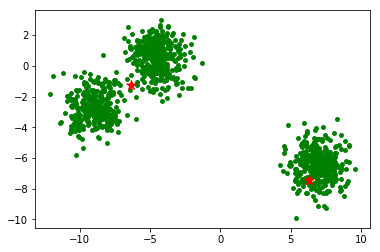

In [11]:
c3 = ctrnew[0, :]
c4 = ctrnew[1, :]

plt.scatter(f1, f2, c='green', s=15)

X = (list(zip(f1, f2)))

plt.scatter(c4, c3, marker='*',c='red',s=100)

# End of the own implemented mini batch algorithm

There are two flaws which I could not solve

    The Algorithm only works with two centroids. Increasing their amount results in an error:
    
       --> ValueError: operands could not be broadcast together with shapes (2,) (1,3)
    
    
The cenroids can be created randomly, but they can not be assigned to the minibatch function if (k > 2) 

## 3. Comparison with SkitLearn

In [12]:
start6 = time.time()
kmeans = MiniBatchKMeans(n_clusters=k, 
                         random_state=0, 
                         batch_size=batch_s)
i = 0

while (i < n_iterations):
    kmeans = kmeans.partial_fit(a[(0 + batch_s * i):(batch_s + batch_s * i),:])
    i+=1
end6 = time.time()
    
kmeans.cluster_centers_


array([[ 6.92598584, -6.43191022],
       [-6.7472807 , -1.09022621]])

In [13]:
start7 = time.time()
kmeans = MiniBatchKMeans(n_clusters=k, 
                         random_state=0, 
                         batch_size=batch_s,
                        max_iter=n_iterations).fit(a)
end7 = time.time()
kmeans.cluster_centers_

timeskit = (end6 - start6) + (end7 - start7) 

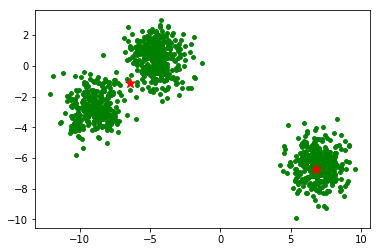

In [14]:
c3 = kmeans.cluster_centers_[0, :]
c4 = kmeans.cluster_centers_[1, :]

plt.scatter(f1, f2, c='green', s=15)

X = (list(zip(f1, f2)))

plt.scatter(c4, c3, marker='*',c='red',s=100)

In [15]:
print(timeown)
print(timeskit)

0.3116183280944824
0.03997635841369629


# All in all 

The own implemented algorithm prooved not ony to be slower than skitlearn but also technically absent.

Batch_generator matrix function works good, 
The order of the mirrored centroids is observable, further proposals about the project would be focussing on the aforementioned two flaw.